# Diffusion equation on a sphere

We solve
$$
\partial_t c = D \nabla^2 c
$$
on a unit sphere $S^2$. Use spherical polar coodinates $0 \leq \theta \leq \pi$ and $0 \leq \phi < 2\pi$. With the initial condition 
$$
c(\theta, \phi, t=0) = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} c_{lm} \; Y_{lm}(\theta, \phi),
$$
where $Y_{lm}(\theta, \phi)$ are the scalar spherical harmonics and $c_{lm}$ are the expansion coefficients, the exact solution is
$$
c(\theta, \phi, t) = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} c_{lm} \; e^{-D \, l \, (l+1) \, t} \; Y_{lm}(\theta, \phi).
$$


In [135]:
from mpi4py import MPI
import dolfinx as dfx
import basix, ufl
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import numpy as np
import vtk
import pyvista as pv
pv.set_jupyter_backend('trame')

In [136]:
# diffusion constant
D,A = 0.1,0
# time extent
T, dt = 10, 1e-2
# timepoints
nt = int(T/dt) + 1
times = np.linspace(0, T, nt)
c_0,m,l = 2,0,1

In [137]:
# mesh
meshfile ='sphere.xdmf'
with dfx.io.XDMFFile(MPI.COMM_WORLD, meshfile, "r") as xdmf:
    domain = xdmf.read_mesh(name="Grid")

# geometrical and topological dimension
gdim, tdim = domain.geometry.dim, domain.topology.dim
x = domain.geometry.x[:,0]


In [138]:
print(gdim,tdim)

3 2


In [139]:
# scalar and vector elements
scalar_element = basix.ufl.element("P", domain.basix_cell(), 1)
vector_element = basix.ufl.element("P", domain.basix_cell(), 1, shape=(gdim,))
print(scalar_element,vector_element)

Basix element (P, triangle, 1, gll_warped, unset, False, float64, []) blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (3,))


In [140]:
# scalar and vector function spaces
SFS = dfx.fem.functionspace(domain, scalar_element)
VFS = dfx.fem.functionspace(domain, vector_element)
print(SFS,VFS)

FunctionSpace(<Mesh #6>, Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])) FunctionSpace(<Mesh #6>, blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (3,)))


In [141]:
# functions at t, td-t, and test-function
u0 = dfx.fem.Function(SFS)
u = dfx.fem.Function(SFS)
tu = ufl.TestFunction(SFS)
#We have defined test and trial function 
#So every pt on sphere has some assotiated scalar value
u_exact = dfx.fem.Function(SFS)

At t=0, the initial c is given by,
$$
c(\theta, \phi, t=0) = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} c_{lm} \; Y_{lm}(\theta, \phi),
$$
For l=1,m=0,
$$
c(\theta, \phi, t=0) =  c_{10} \; Y_{10}(\theta, \phi) = c_{10} \sqrt{\frac{3}{4\pi}} \cos{\theta},
$$

In [142]:
# initial condition
r = lambda x : np.sqrt(x[0]**2 + x[1]**2+x[2]**2)
r_x = lambda x : np.sqrt(x[0]**2 + x[1]**2)
theta = lambda x: np.pi/2+np.arctan(x[1],x[0])
phi = lambda x: np.arctan2(r_x(x),x[2])
#def Qfun(x,theta):
#    return (np.sqrt(3/(4*np.pi))*np.cos(theta(x)))
#u0.interpolate(lambda x: c_0*Qfun(x,theta))



The exact solution is given by,
$$
c(\theta, \phi, t) = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} c_{lm} \; e^{-D \, l \, (l+1) \, t} \; Y_{lm}(\theta, \phi).
$$

In [143]:

def Q_ex(x,theta,t):
    return c_0*(np.sqrt(3/(4*np.pi))*np.cos(theta(x)))*np.exp(-D*l*(l+1)*t)
u_exact.interpolate(lambda x,t=0: Q_ex(x,theta,t))
u0.interpolate(lambda x,t=0: Q_ex(x,theta,t))
#print(u0.x.array)

In [144]:
# unit normal & tangential projector

normal = dfx.fem.Function(VFS)
normal.interpolate(lambda x: x/r(x))
projector = ufl.Identity(gdim) - ufl.outer(normal, normal)

print(normal)
print(projector)

f
I + ({ A | A_{i_{50}, i_{51}} = -1 * ((f) (X) (f))[i_{50}, i_{51}] })


In [145]:
# weak-form
form = (ufl.dot((u-u0)/dt, tu) 
        + D * ufl.inner(projector * ufl.grad(u), projector * ufl.grad(tu)))*ufl.dx

In [146]:
# setup problem and solver
problem = NonlinearProblem(form, u, bcs=[])
solver = NewtonSolver(MPI.COMM_WORLD, problem)

In [147]:
#Setting up an array to store the scalar function over the domain for each time step
uarray = np.zeros((nt, len(u.x.array)))
u_ex_array = np.zeros((nt, len(u.x.array)))
#print(uarray)
uarray[0] = u0.x.array
u_ex_array[0] = u_exact.x.array
print(uarray)
print(u_ex_array)
#gradu_array = np.zeros(nt, len(vel.x.array))
#print(gradu_array)

[[-0.45004626 -0.48143524 -0.52781176 ...  0.49519533  0.39487806
   0.44993867]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.45004626 -0.48143524 -0.52781176 ...  0.49519533  0.39487806
   0.44993867]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [148]:
# time-evolution
err_array = np.zeros( nt)
L2_error = dfx.fem.form(ufl.inner( u0 - u_exact, u0- u_exact) * ufl.dx)
error_local = dfx.fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
err_array[0] = error_L2 
for tt in range(1, nt):
    solver.solve(u)
    u0.x.array[:] = u.x.array
    uarray[tt] = u0.x.array
    u_exact.interpolate(lambda x,t=tt*dt: Q_ex(x,theta,t))
    u_ex_array[tt] = u_exact.x.array
    L2_error = dfx.fem.form(ufl.inner( u - u_exact, u- u_exact) * ufl.dx)
    error_local = dfx.fem.assemble_scalar(L2_error)
    error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
    err_array[tt]=error_L2
    
print(uarray)
# So uarray has all the values of all the points on a sphere at each timestep

[[-0.45004626 -0.48143524 -0.52781176 ...  0.49519533  0.39487806
   0.44993867]
 [-0.44872058 -0.48014041 -0.52659489 ...  0.49391956  0.3935454
   0.44861318]
 [-0.4474001  -0.47884918 -0.52537867 ...  0.4926456   0.39222169
   0.44729287]
 ...
 [-0.05466247 -0.05964461 -0.06761388 ...  0.06192618  0.04654392
   0.05464664]
 [-0.05455285 -0.05952499 -0.06747828 ...  0.06180199  0.04645058
   0.05453705]
 [-0.05444344 -0.05940561 -0.06734295 ...  0.06167805  0.04635742
   0.05442767]]


In [149]:
topology, cell_types, positions = dfx.plot.vtk_mesh(VFS)
vgrid = pv.UnstructuredGrid(topology, cell_types, positions)
print(vgrid)
topology, cell_types, positions = dfx.plot.vtk_mesh(SFS)
sgrid = pv.UnstructuredGrid(topology, cell_types, positions)
print(sgrid)


UnstructuredGrid (0x74ebe4091a20)
  N Cells:    1280
  N Points:   642
  X Bounds:   -9.998e-01, 9.999e-01
  Y Bounds:   -1.000e+00, 1.000e+00
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   0
UnstructuredGrid (0x74ebe40926e0)
  N Cells:    1280
  N Points:   642
  X Bounds:   -9.998e-01, 9.999e-01
  Y Bounds:   -1.000e+00, 1.000e+00
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   0


In [150]:
topology, cell_types, positions = dfx.plot.vtk_mesh(VFS)
#vgrid = pv.UnstructuredGrid(topology, cell_types, positions)

topology, cell_types, positions = dfx.plot.vtk_mesh(SFS)
sgrid = pv.UnstructuredGrid(topology, cell_types, positions)

umin, umax = u_ex_array.min(), u_ex_array.max()
cmap, n_colors = 'coolwarm', 11
vector_scale, vector_color = 0.1, 'black'

pl = pv.Plotter()

#plot scalars
scalar_bar_args={'title':r'u', 'n_labels':3,
                'fmt':'%3.1f', 'vertical':True, 
                'height':0.5, 'width':0.05}
sgrid.point_data['u'] = uarray[0]
smesh = pl.add_mesh(sgrid, cmap=cmap, show_scalar_bar=True, n_colors=n_colors,
                 smooth_shading=True, clim=(umin, umax), 
                 scalar_bar_args=scalar_bar_args, name='u')
# plot vectors

def update(idx):
    global smesh
    global vmesh
    pl.remove_actor(smesh)
    
    sgrid.point_data['u'] = uarray[idx]
    
    smesh = pl.add_mesh(sgrid, cmap=cmap, show_scalar_bar=True, n_colors=n_colors,
                     smooth_shading=True, clim=(umin, umax), 
                     scalar_bar_args=scalar_bar_args, name='u')
    


def slider_update(value):
    idx = (abs(times-value)).argmin()
    update(idx)
    return

slider = pl.add_slider_widget(slider_update, 
                                rng=[times.min(), times.max()], value=times.min(), 
                                title=r'αt', style='modern',
                                interaction_event='always',
                                pointa=(0.35, 0.1), pointb=(0.75, 0.1), 
                                slider_width=0.03, tube_width=0.03,
                                fmt='%3.1f')

pl.show()

Widget(value='<iframe src="http://localhost:44033/index.html?ui=P_0x74ebb8d17610_25&reconnect=auto" class="pyv…

Text(0.5, 0, 'time')

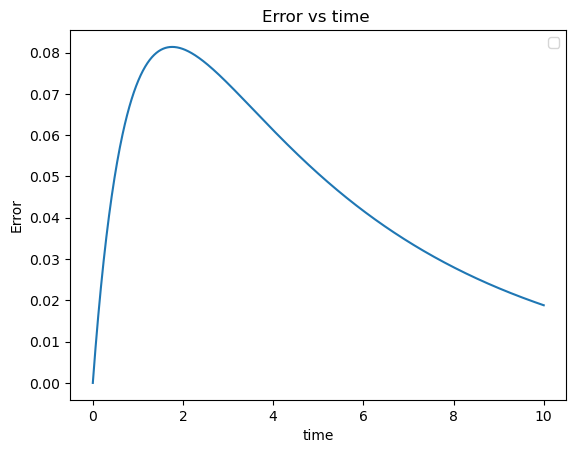

In [151]:
import matplotlib.pyplot as plt
plt.plot(times, err_array)
plt.legend()
plt.title("Error vs time ")
plt.ylabel("Error")
plt.xlabel("time")

In [152]:
topology, cell_types, positions = dfx.plot.vtk_mesh(VFS)
#vgrid = pv.UnstructuredGrid(topology, cell_types, positions)

topology, cell_types, positions = dfx.plot.vtk_mesh(SFS)
sgrid1 = pv.UnstructuredGrid(topology, cell_types, positions)

umin, umax = u_ex_array.min(), u_ex_array.max()
cmap, n_colors = 'coolwarm', 11
vector_scale, vector_color = 0.1, 'black'

pl = pv.Plotter()

#plot scalars
scalar_bar_args={'title':r'u', 'n_labels':3,
                'fmt':'%3.1f', 'vertical':True, 
                'height':0.5, 'width':0.05}
sgrid1.point_data['u'] = u_ex_array[0]
smesh1 = pl.add_mesh(sgrid1, cmap=cmap, show_scalar_bar=True, n_colors=n_colors,
                 smooth_shading=True, clim=(umin, umax), 
                 scalar_bar_args=scalar_bar_args, name='u')
# plot vectors

def update(idx):
    global smesh1
    
    pl.remove_actor(smesh1)
    
    sgrid1.point_data['u'] = u_ex_array[idx]
    
    smesh1 = pl.add_mesh(sgrid1, cmap=cmap, show_scalar_bar=True, n_colors=n_colors,
                     smooth_shading=True, clim=(umin, umax), 
                     scalar_bar_args=scalar_bar_args, name='u')
    


def slider_update(value):
    idx = (abs(times-value)).argmin()
    update(idx)
    return

slider = pl.add_slider_widget(slider_update, 
                                rng=[times.min(), times.max()], value=times.min(), 
                                title=r'αt', style='modern',
                                interaction_event='always',
                                pointa=(0.35, 0.1), pointb=(0.75, 0.1), 
                                slider_width=0.03, tube_width=0.03,
                                fmt='%3.1f')

pl.show()

Widget(value='<iframe src="http://localhost:44033/index.html?ui=P_0x74ebb8dc9790_26&reconnect=auto" class="pyv…

In [153]:
print(u_ex_array)

[[-0.45004626 -0.48143524 -0.52781176 ...  0.49519533  0.39487806
   0.44993867]
 [-0.44914707 -0.48047333 -0.52675719 ...  0.49420593  0.39408909
   0.44903969]
 [-0.44824968 -0.47951334 -0.52570473 ...  0.49321851  0.3933017
   0.44814251]
 ...
 [-0.06115126 -0.06541632 -0.07171785 ...  0.06728601  0.05365513
   0.06113664]
 [-0.06102907 -0.06528561 -0.07157456 ...  0.06715157  0.05354792
   0.06101448]
 [-0.06090714 -0.06515517 -0.07143155 ...  0.0670174   0.05344093
   0.06089258]]
